# EV 배터리 공급망 데이터 전처리 파이프라인

이 노트북은 무역 데이터를 EV 배터리 공급망 도메인 관점에서 전처리합니다.

## 전처리 단계
1. 기본 로드 & 보조 컬럼 생성
2. item_id-hs4 매핑 확보
3. (item_id, year, month) 단위 월별 집계
4. EV 배터리 공급망 도메인 클러스터 라벨링
5. quantity 처리 (구조적 결측 반영)
6. 0값 기반 "사실상 결측" 플래그
7. weight_sum / value_sum 결측성 보정
8. 극단값(이상치) 처리: 클리핑 + 플래그
9. 로그 변환 피처
10. 아이템별 변동성 시각화
11. 최종 결과 저장


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

print("라이브러리 로드 완료")


라이브러리 로드 완료


## 1️⃣ 기본 로드 & 보조 컬럼 생성


In [2]:
# train.csv를 로드하고 year, month로 ym 컬럼 생성
df_train = pd.read_csv('../data/train.csv')

# year, month를 이용해 datetime 컬럼 생성
df_train['ym'] = pd.to_datetime(
    df_train['year'].astype(str) + "-" + df_train['month'].astype(str).str.zfill(2) + "-01"
)

print(f"데이터 로드 완료: {len(df_train):,}행")
print(f"컬럼: {df_train.columns.tolist()}")
df_train.head()


데이터 로드 완료: 10,836행
컬럼: ['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity', 'value', 'ym']


,item_id,year,month,seq,type,hs4,weight,quantity,value,ym
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,2022-01-01
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,2022-01-01
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,2022-01-01
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0,2022-01-01
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0,2022-01-01


## 2️⃣ item_id-hs4 매핑 확보


In [3]:
# 같은 item_id는 항상 동일한 hs4를 가진다는 가정
# (item_id, hs4) 유일 조합으로 매핑 테이블 생성
item_hs4_map = (
    df_train[['item_id', 'hs4']]
    .drop_duplicates()
    .set_index('item_id')['hs4']
    .to_dict()
)

print(f"item_id-hs4 매핑 완료: {len(item_hs4_map):,}개 item_id")
print(f"예시: {list(item_hs4_map.items())[:5]}")


item_id-hs4 매핑 완료: 100개 item_id
예시: [('DEWLVASR', 3038), ('ELQGMQWE', 2002), ('AHMDUILJ', 2102), ('XIPPENFQ', 2501), ('FTSVTTSR', 2529)]


## 3️⃣ (item_id, year, month) 단위 월별 집계


In [4]:
# value, weight, quantity를 합산하여 월별 집계 생성
monthly_features = (
    df_train.groupby(['item_id', 'year', 'month'], as_index=False)
    .agg({
        'value': 'sum',
        'weight': 'sum',
        'quantity': 'sum',
        'ym': 'first'  # ym은 동일하므로 first 사용
    })
    .rename(columns={
        'value': 'value_sum',
        'weight': 'weight_sum',
        'quantity': 'quantity_sum'
    })
)

# item_id-hs4 매핑 적용
monthly_features['hs4'] = monthly_features['item_id'].map(item_hs4_map)

print(f"월별 집계 완료: {len(monthly_features):,}행")
monthly_features.head()


월별 집계 완료: 3,776행


,item_id,year,month,value_sum,weight_sum,quantity_sum,ym,hs4
0,AANGBULD,2022,1,14276.0,17625.0,0.0,2022-01-01,4810
1,AANGBULD,2022,2,52347.0,67983.0,0.0,2022-02-01,4810
2,AANGBULD,2022,3,53549.0,69544.0,0.0,2022-03-01,4810
3,AANGBULD,2022,5,26997.0,34173.0,0.0,2022-05-01,4810
4,AANGBULD,2022,6,84489.0,103666.0,0.0,2022-06-01,4810


## 4️⃣ EV 배터리 공급망 도메인 클러스터 라벨링


In [5]:
# hs4를 문자열로 변환하고 HS2 추출
hs4_str = monthly_features['hs4'].astype(str).str.zfill(4)
monthly_features['hs2'] = hs4_str.str[:2]

# 클러스터 라벨링 함수
def assign_cluster(hs2):
    if hs2 in ["27", "28", "29", "31", "38", "39", "72", "79", "81"]:
        return "battery_materials"  # 배터리 소재·화학·금속
    elif hs2 in ["84", "85", "87", "90"]:
        return "ev_machinery_electrical"  # EV·설비·전기기기
    else:
        return "other_industries"  # 기타 산업

monthly_features['cluster'] = monthly_features['hs2'].apply(assign_cluster)

print("클러스터 라벨링 완료")
print(monthly_features['cluster'].value_counts())
monthly_features[['item_id', 'hs4', 'hs2', 'cluster']].head(10)


클러스터 라벨링 완료
cluster
battery_materials          1818
other_industries           1364
ev_machinery_electrical     594
Name: count, dtype: int64


,item_id,hs4,hs2,cluster
0,AANGBULD,4810,48,other_industries
1,AANGBULD,4810,48,other_industries
2,AANGBULD,4810,48,other_industries
3,AANGBULD,4810,48,other_industries
4,AANGBULD,4810,48,other_industries
5,AANGBULD,4810,48,other_industries
6,AANGBULD,4810,48,other_industries
7,AANGBULD,4810,48,other_industries
8,AANGBULD,4810,48,other_industries
9,AANGBULD,4810,48,other_industries


## 5️⃣ quantity 처리 (구조적 결측 반영)


In [6]:
# hs4별로 quantity_sum > 0인 row가 하나라도 있는지 확인
hs4_has_quantity = (
    monthly_features.groupby('hs4')['quantity_sum']
    .apply(lambda x: (x > 0).any())
    .to_dict()
)

# 해당 hs4에서 quantity 정보가 의미 있는지 플래그
monthly_features['has_quantity_info_hs4'] = monthly_features['hs4'].map(hs4_has_quantity).astype(int)

# 현재 row의 quantity_sum > 0 여부
monthly_features['has_quantity_this_row'] = (monthly_features['quantity_sum'] > 0).astype(int)

print("Quantity 처리 완료")
print(f"  - 수량 정보 의미 있는 HS4: {monthly_features['has_quantity_info_hs4'].sum():,}행")
print(f"  - 수량 존재하는 행: {monthly_features['has_quantity_this_row'].sum():,}행")
monthly_features[['hs4', 'quantity_sum', 'has_quantity_info_hs4', 'has_quantity_this_row']].head(10)


Quantity 처리 완료
  - 수량 정보 의미 있는 HS4: 746행
  - 수량 존재하는 행: 703행


,hs4,quantity_sum,has_quantity_info_hs4,has_quantity_this_row
0,4810,0.0,0,0
1,4810,0.0,0,0
2,4810,0.0,0,0
3,4810,0.0,0,0
4,4810,0.0,0,0
5,4810,0.0,0,0
6,4810,0.0,0,0
7,4810,0.0,0,0
8,4810,0.0,0,0
9,4810,0.0,0,0


## 6️⃣ 0값 기반 "사실상 결측" 플래그


In [7]:
# 기본 0값 플래그
monthly_features['weight_zero_flag'] = (monthly_features['weight_sum'] == 0).astype(int)
monthly_features['value_zero_flag'] = (monthly_features['value_sum'] == 0).astype(int)

# 사실상 결측 플래그
# weight가 0인데 value는 있음 → 무게 정보 미기입 가능성
monthly_features['weight_missing_flag'] = (
    (monthly_features['weight_sum'] == 0) & (monthly_features['value_sum'] > 0)
).astype(int)

# value가 0인데 weight는 있음 → 금액 정보 미기입 가능성
monthly_features['value_missing_flag'] = (
    (monthly_features['value_sum'] == 0) & (monthly_features['weight_sum'] > 0)
).astype(int)

print("0값/결측 플래그 생성 완료")
print(f"  - weight_zero_flag: {monthly_features['weight_zero_flag'].sum():,}행")
print(f"  - value_zero_flag: {monthly_features['value_zero_flag'].sum():,}행")
print(f"  - weight_missing_flag: {monthly_features['weight_missing_flag'].sum():,}행")
print(f"  - value_missing_flag: {monthly_features['value_missing_flag'].sum():,}행")


0값/결측 플래그 생성 완료
  - weight_zero_flag: 91행
  - value_zero_flag: 0행
  - weight_missing_flag: 91행
  - value_missing_flag: 0행


## 7️⃣ weight_sum / value_sum 결측성 보정


In [8]:
# 중앙값 사전 계산 (효율성을 위해 dict로 저장)
item_weight_median = monthly_features.groupby('item_id')['weight_sum'].median().to_dict()
hs4_weight_median = monthly_features.groupby('hs4')['weight_sum'].median().to_dict()
global_weight_median = monthly_features['weight_sum'].median()

item_value_median = monthly_features.groupby('item_id')['value_sum'].median().to_dict()
hs4_value_median = monthly_features.groupby('hs4')['value_sum'].median().to_dict()
global_value_median = monthly_features['value_sum'].median()

print(f"중앙값 계산 완료")
print(f"  - 전체 weight 중앙값: {global_weight_median:,.0f}")
print(f"  - 전체 value 중앙값: {global_value_median:,.0f}")


중앙값 계산 완료
  - 전체 weight 중앙값: 27,536
  - 전체 value 중앙값: 382,516


In [9]:
# weight_filled: weight_missing_flag == 1인 경우 계층적 보정
monthly_features['weight_filled'] = monthly_features['weight_sum'].copy()

missing_weight_mask = monthly_features['weight_missing_flag'] == 1
if missing_weight_mask.sum() > 0:
    # item_id 중앙값으로 먼저 시도
    monthly_features.loc[missing_weight_mask, 'weight_filled'] = (
        monthly_features.loc[missing_weight_mask, 'item_id'].map(item_weight_median)
    )
    
    # item_id 중앙값이 없거나 0인 경우 hs4 중앙값으로
    still_missing = (monthly_features['weight_filled'].isna()) | (monthly_features['weight_filled'] == 0)
    monthly_features.loc[still_missing & missing_weight_mask, 'weight_filled'] = (
        monthly_features.loc[still_missing & missing_weight_mask, 'hs4'].map(hs4_weight_median)
    )
    
    # 그것도 안 되면 전체 중앙값
    still_missing = (monthly_features['weight_filled'].isna()) | (monthly_features['weight_filled'] == 0)
    monthly_features.loc[still_missing & missing_weight_mask, 'weight_filled'] = global_weight_median

print(f"weight_filled 보정 완료: {missing_weight_mask.sum():,}행")


weight_filled 보정 완료: 91행


In [10]:
# value_filled: value_missing_flag == 1인 경우 계층적 보정
monthly_features['value_filled'] = monthly_features['value_sum'].copy()

missing_value_mask = monthly_features['value_missing_flag'] == 1
if missing_value_mask.sum() > 0:
    # item_id 중앙값으로 먼저 시도
    monthly_features.loc[missing_value_mask, 'value_filled'] = (
        monthly_features.loc[missing_value_mask, 'item_id'].map(item_value_median)
    )
    
    # item_id 중앙값이 없거나 0인 경우 hs4 중앙값으로
    still_missing = (monthly_features['value_filled'].isna()) | (monthly_features['value_filled'] == 0)
    monthly_features.loc[still_missing & missing_value_mask, 'value_filled'] = (
        monthly_features.loc[still_missing & missing_value_mask, 'hs4'].map(hs4_value_median)
    )
    
    # 그것도 안 되면 전체 중앙값
    still_missing = (monthly_features['value_filled'].isna()) | (monthly_features['value_filled'] == 0)
    monthly_features.loc[still_missing & missing_value_mask, 'value_filled'] = global_value_median

print(f"value_filled 보정 완료: {missing_value_mask.sum():,}행")
monthly_features[['weight_sum', 'weight_filled', 'value_sum', 'value_filled', 
                  'weight_missing_flag', 'value_missing_flag']].head(10)


value_filled 보정 완료: 0행


,weight_sum,weight_filled,value_sum,value_filled,weight_missing_flag,value_missing_flag
0,17625.0,17625.0,14276.0,14276.0,0,0
1,67983.0,67983.0,52347.0,52347.0,0,0
2,69544.0,69544.0,53549.0,53549.0,0,0
3,34173.0,34173.0,26997.0,26997.0,0,0
4,103666.0,103666.0,84489.0,84489.0,0,0
5,67.0,67.0,299.0,299.0,0,0
6,66.0,66.0,574.0,574.0,0,0
7,50281.0,50281.0,41353.0,41353.0,0,0
8,32345.0,32345.0,26524.0,26524.0,0,0
9,70.0,70.0,340.0,340.0,0,0


## 8️⃣ 극단값(이상치) 처리: 클리핑 + 플래그


In [11]:
# 99 분위수 계산
q99_value = monthly_features['value_filled'].quantile(0.99)
q99_weight = monthly_features['weight_filled'].quantile(0.99)
q99_quantity = monthly_features['quantity_sum'].quantile(0.99)

print(f"99 분위수:")
print(f"  - value: {q99_value:,.0f}")
print(f"  - weight: {q99_weight:,.0f}")
print(f"  - quantity: {q99_quantity:,.0f}")

# 극단값 플래그
monthly_features['value_extreme_flag'] = (monthly_features['value_filled'] > q99_value).astype(int)
monthly_features['weight_extreme_flag'] = (monthly_features['weight_filled'] > q99_weight).astype(int)
monthly_features['quantity_extreme_flag'] = (monthly_features['quantity_sum'] > q99_quantity).astype(int)

# 클리핑된 컬럼 생성
monthly_features['value_clip'] = np.minimum(monthly_features['value_filled'], q99_value)
monthly_features['weight_clip'] = np.minimum(monthly_features['weight_filled'], q99_weight)
monthly_features['quantity_clip'] = np.minimum(monthly_features['quantity_sum'], q99_quantity)

print(f"\n이상치 처리 완료")
print(f"  - value_extreme_flag: {monthly_features['value_extreme_flag'].sum():,}행")
print(f"  - weight_extreme_flag: {monthly_features['weight_extreme_flag'].sum():,}행")
print(f"  - quantity_extreme_flag: {monthly_features['quantity_extreme_flag'].sum():,}행")


99 분위수:
  - value: 103,704,968
  - weight: 76,572,396
  - quantity: 1,545,930

이상치 처리 완료
  - value_extreme_flag: 38행
  - weight_extreme_flag: 38행
  - quantity_extreme_flag: 38행


## 9️⃣ 로그 변환 피처


## 📊 아이템별 변동성 시각화 (원본 데이터 기준)

⚠️ **주의**: 이 섹션은 **보정/클리핑 없이 원본 데이터(`value_sum`)로 변동성을 계산**합니다.
- 결측치 중앙값 보정 없음
- 극단값 클리핑 없음
- 원본 데이터 그대로 사용


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (macOS의 경우)
try:
    plt.rcParams['font.family'] = 'AppleGothic'
except:
    plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# 원본 데이터로 변동성 계산 (보정/클리핑 없음)
# ============================================================
print("="*70)
print("아이템별 변동성 분석 (원본 데이터 기준)")
print("="*70)
print("⚠️  결측치 보정 없음, 극단값 처리 없음")
print("="*70)

# 아이템별 변동성 지표 계산 (원본 value_sum 사용)
volatility_metrics = []

for item_id in monthly_features['item_id'].unique():
    item_data = monthly_features[monthly_features['item_id'] == item_id].sort_values('ym')
    
    if len(item_data) < 2:
        continue
    
    # 원본 데이터 사용 (보정/클리핑 없음)
    # value_sum 컬럼이 있는지 확인
    if 'value_sum' not in item_data.columns:
        continue
    
    value_series = item_data['value_sum'].values
    
    # 0이 아닌 값만 사용 (실제 거래가 있는 경우만)
    non_zero_mask = value_series > 0
    if non_zero_mask.sum() < 2:  # 0이 아닌 값이 2개 미만이면 스킵
        continue
    
    value_nonzero = value_series[non_zero_mask]
    
    # 로그 변환 (원본 값 기준) - 직접 계산 (log_value 컬럼 사용 안 함)
    log_value_series = np.log1p(value_nonzero)
    
    # 변화율 계산 (원본 값 기준)
    pct_changes = item_data['value_sum'].pct_change().dropna()
    # inf, -inf 제거
    pct_changes = pct_changes[np.isfinite(pct_changes)]
    pct_change_std = np.std(pct_changes) if len(pct_changes) > 0 else 0
    
    # 변동성 지표 계산 (원본 데이터 기준)
    metrics = {
        'item_id': item_id,
        'hs4': item_data['hs4'].iloc[0],
        'cluster': item_data['cluster'].iloc[0],
        'n_months': len(item_data),
        'n_nonzero': non_zero_mask.sum(),  # 0이 아닌 월 수
        'mean_value': np.mean(value_nonzero) if len(value_nonzero) > 0 else 0,
        'std_value': np.std(value_nonzero) if len(value_nonzero) > 0 else 0,
        'cv_value': np.std(value_nonzero) / (np.mean(value_nonzero) + 1e-8) if len(value_nonzero) > 0 else 0,  # 변동계수
        'range_value': np.max(value_nonzero) - np.min(value_nonzero) if len(value_nonzero) > 0 else 0,
        'max_value': np.max(value_nonzero) if len(value_nonzero) > 0 else 0,
        'min_value': np.min(value_nonzero) if len(value_nonzero) > 0 else 0,
        'std_log_value': np.std(log_value_series) if len(log_value_series) > 0 else 0,  # 로그 변환 후 표준편차
        'pct_change_std': pct_change_std,  # 변화율의 표준편차
        'zero_ratio': 1 - (non_zero_mask.sum() / len(value_series)),  # 0값 비율
    }
    volatility_metrics.append(metrics)

volatility_df = pd.DataFrame(volatility_metrics)

print(f"\n총 {len(volatility_df)}개 아이템 분석 (2개월 이상 데이터 있는 아이템)")
print(f"\n변동성 지표 요약:")
print(volatility_df[['cv_value', 'std_value', 'range_value', 'pct_change_std', 'zero_ratio']].describe())

print(f"\n원본 데이터 통계:")
print(f"  - 평균 0값 비율: {volatility_df['zero_ratio'].mean():.2%}")
print(f"  - 최대값 범위: {volatility_df['max_value'].min():,.0f} ~ {volatility_df['max_value'].max():,.0f}")

volatility_df.head(10)


아이템별 변동성 분석 (원본 데이터 기준)
⚠️  결측치 보정 없음, 극단값 처리 없음

총 99개 아이템 분석 (2개월 이상 데이터 있는 아이템)

변동성 지표 요약:
        cv_value     std_value   range_value  pct_change_std  zero_ratio
count  99.000000  9.900000e+01  9.900000e+01       99.000000        99.0
mean    0.833150  1.836808e+06  7.740079e+06      582.800835         0.0
std     0.620679  4.495521e+06  1.863903e+07     3242.191826         0.0
min     0.073778  7.642571e+01  1.720000e+02        0.092732         0.0
25%     0.454722  6.921887e+04  3.333430e+05        0.686473         0.0
50%     0.671176  2.750727e+05  1.187453e+06        1.765466         0.0
75%     1.023954  1.133050e+06  4.807450e+06        9.399990         0.0
max     4.281637  3.234730e+07  1.207664e+08    26400.880024         0.0

원본 데이터 통계:
  - 평균 0값 비율: 0.00%
  - 최대값 범위: 200 ~ 146,216,818


,item_id,hs4,cluster,n_months,n_nonzero,mean_value,std_value,cv_value,range_value,max_value,min_value,std_log_value,pct_change_std,zero_ratio
0,AANGBULD,4810,other_industries,29,29,1.245780e+05,1.597402e+05,1.282251,533179.0,533478.0,299.0,1.914739,25.365012,0.0
1,AHMDUILJ,2102,other_industries,43,43,1.268288e+05,4.551154e+04,0.358842,213474.0,242705.0,29231.0,0.428317,0.924065,0.0
2,ANWUJOKX,4403,other_industries,8,8,4.378862e+04,2.577551e+04,0.588635,73200.0,81670.0,8470.0,0.702737,3.097364,0.0
3,APQGTRMF,8105,battery_materials,42,42,2.633321e+05,2.082345e+05,0.790767,759903.0,759980.0,77.0,1.925900,43.711495,0.0
4,ATLDMDBO,2814,battery_materials,43,43,5.999737e+07,3.234730e+07,0.539145,120766406.0,146216818.0,25450412.0,0.500180,0.407906,0.0
5,AXULOHBQ,5515,other_industries,43,43,9.626409e+04,6.868763e+04,0.713533,332834.0,344263.0,11429.0,0.715159,0.730267,0.0
6,BEZYMBBT,3207,other_industries,43,43,4.939373e+06,9.886921e+05,0.200166,4288428.0,6889516.0,2601088.0,0.216815,0.288579,0.0
7,BJALXPFS,2847,battery_materials,43,43,1.644843e+05,9.111696e+04,0.553955,335347.0,352827.0,17480.0,0.659736,2.085231,0.0
8,BLANHGYY,9022,ev_machinery_electrical,29,29,1.866514e+04,2.789603e+04,1.494553,128168.0,128334.0,166.0,1.519536,21.127016,0.0
9,BSRMSVTC,2805,battery_materials,43,43,5.216824e+05,5.739169e+05,1.100127,3501724.0,3563685.0,61961.0,0.815308,2.079891,0.0


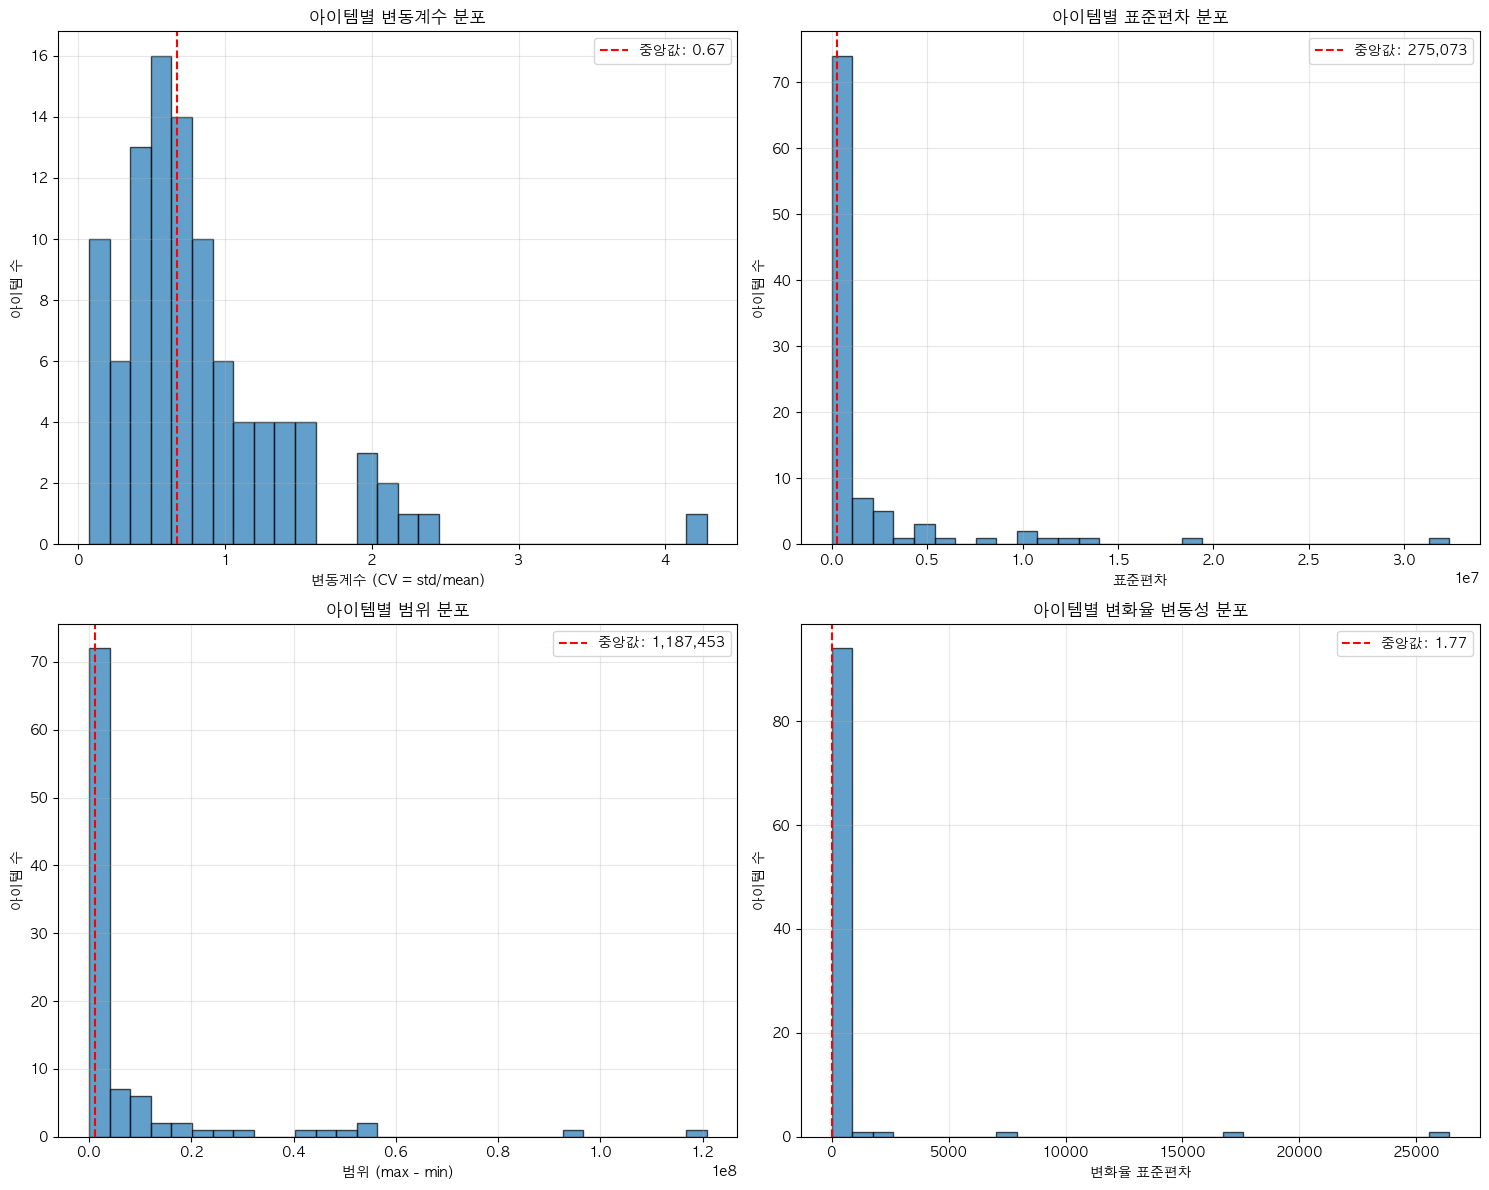

In [13]:
# 1. 변동계수(CV) 분포 히스토그램
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1-1. 변동계수 분포
axes[0, 0].hist(volatility_df['cv_value'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(volatility_df['cv_value'].median(), color='red', linestyle='--', 
                   label=f'중앙값: {volatility_df["cv_value"].median():.2f}')
axes[0, 0].set_xlabel('변동계수 (CV = std/mean)')
axes[0, 0].set_ylabel('아이템 수')
axes[0, 0].set_title('아이템별 변동계수 분포')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 1-2. 표준편차 분포
axes[0, 1].hist(volatility_df['std_value'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(volatility_df['std_value'].median(), color='red', linestyle='--',
                   label=f'중앙값: {volatility_df["std_value"].median():,.0f}')
axes[0, 1].set_xlabel('표준편차')
axes[0, 1].set_ylabel('아이템 수')
axes[0, 1].set_title('아이템별 표준편차 분포')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 1-3. 범위 분포
axes[1, 0].hist(volatility_df['range_value'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(volatility_df['range_value'].median(), color='red', linestyle='--',
                   label=f'중앙값: {volatility_df["range_value"].median():,.0f}')
axes[1, 0].set_xlabel('범위 (max - min)')
axes[1, 0].set_ylabel('아이템 수')
axes[1, 0].set_title('아이템별 범위 분포')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 1-4. 변화율 표준편차 분포
axes[1, 1].hist(volatility_df['pct_change_std'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(volatility_df['pct_change_std'].median(), color='red', linestyle='--',
                   label=f'중앙값: {volatility_df["pct_change_std"].median():.2f}')
axes[1, 1].set_xlabel('변화율 표준편차')
axes[1, 1].set_ylabel('아이템 수')
axes[1, 1].set_title('아이템별 변화율 변동성 분포')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


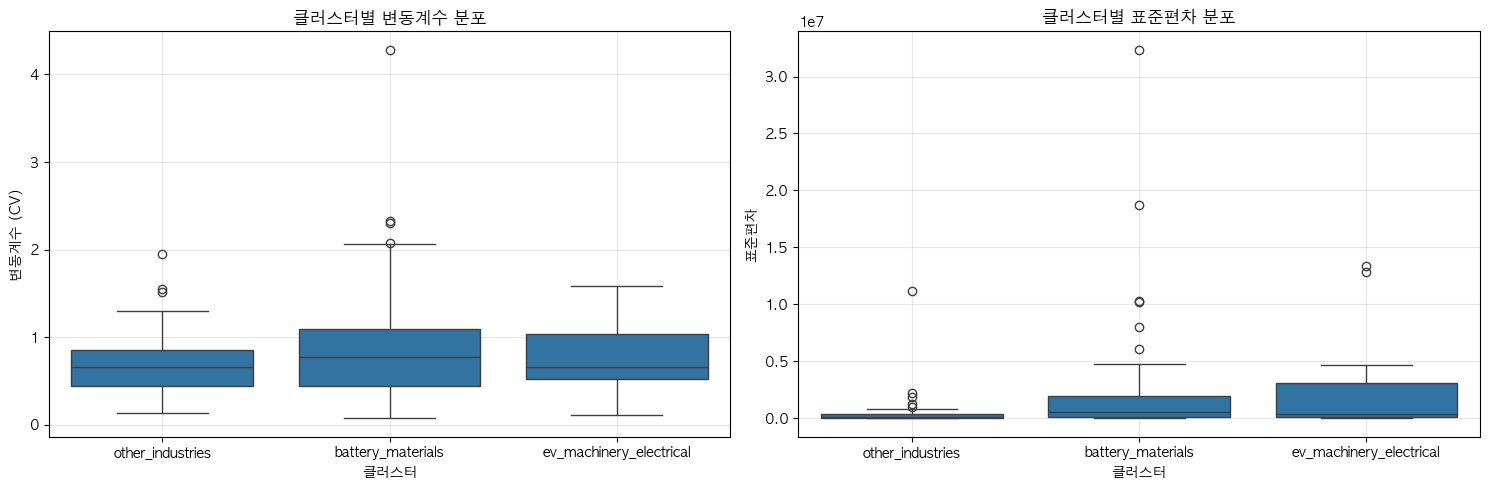


클러스터별 변동성 통계:
                         cv_value                         std_value  \
                             mean    median       std          mean   
cluster                                                               
battery_materials        0.948352  0.768899  0.775775  2.567078e+06   
ev_machinery_electrical  0.789190  0.655962  0.461060  2.518431e+06   
other_industries         0.708934  0.657265  0.417352  6.341482e+05   

                                                       range_value             \
                                median           std          mean     median   
cluster                                                                         
battery_materials        516169.348907  5.748686e+06  1.093002e+07  2223848.0   
ev_machinery_electrical  349297.312001  4.356357e+06  1.039886e+07  1562078.5   
other_industries         114104.910118  1.850447e+06  2.624466e+06   541108.0   

                                       
                               

In [14]:
# 2. 클러스터별 변동성 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 2-1. 클러스터별 변동계수 박스플롯
sns.boxplot(data=volatility_df, x='cluster', y='cv_value', ax=axes[0])
axes[0].set_xlabel('클러스터')
axes[0].set_ylabel('변동계수 (CV)')
axes[0].set_title('클러스터별 변동계수 분포')
axes[0].grid(True, alpha=0.3)

# 2-2. 클러스터별 표준편차 박스플롯
sns.boxplot(data=volatility_df, x='cluster', y='std_value', ax=axes[1])
axes[1].set_xlabel('클러스터')
axes[1].set_ylabel('표준편차')
axes[1].set_title('클러스터별 표준편차 분포')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 클러스터별 변동성 통계
print("\n클러스터별 변동성 통계:")
print(volatility_df.groupby('cluster')[['cv_value', 'std_value', 'range_value']].agg(['mean', 'median', 'std']))


변동성이 높은 아이템 Top 10 (변동계수 기준)
     item_id   hs4                  cluster  cv_value      std_value  \
90  XIIEJNEE  3815        battery_materials  4.281637  591262.147605   
74  SUOYXCHP  2805        battery_materials  2.326177  100173.024095   
27  FWUCPMMW  2701        battery_materials  2.306932    7514.676550   
22  FDXPMYGF  7907        battery_materials  2.073402   11390.438843   
33  IGDVVKUD  3824        battery_materials  2.062092   34752.258147   
50  NAQIHUKZ  3813        battery_materials  1.966899   15319.722904   
37  JSLXRQOK  5119         other_industries  1.952020   31019.929405   
16  DJBLNPNC  2805        battery_materials  1.923474    6076.254402   
89  XIFHSOWQ  8708  ev_machinery_electrical  1.585812  303753.524686   
75  TANNMIMB  4302         other_industries  1.551399    1121.661268   

       mean_value  
90  138092.535714  
74   43063.378378  
27    3257.433333  
22    5493.600000  
33   16852.916667  
50    7788.769231  
37   15891.195122  
16    3159.000000 

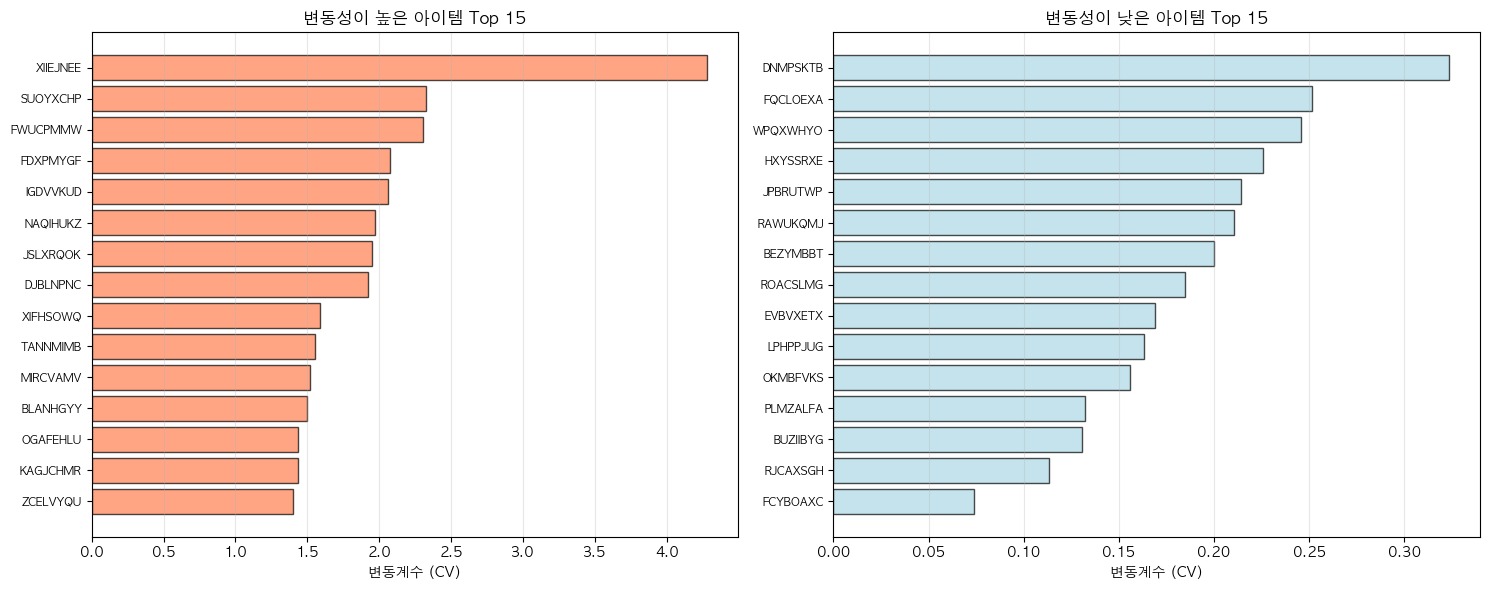

In [15]:
# 3. 변동성이 높은/낮은 아이템 Top 10
volatility_df_sorted = volatility_df.sort_values('cv_value', ascending=False)

print("="*70)
print("변동성이 높은 아이템 Top 10 (변동계수 기준)")
print("="*70)
print(volatility_df_sorted[['item_id', 'hs4', 'cluster', 'cv_value', 'std_value', 'mean_value']].head(10))

print("\n" + "="*70)
print("변동성이 낮은 아이템 Top 10 (변동계수 기준)")
print("="*70)
print(volatility_df_sorted[['item_id', 'hs4', 'cluster', 'cv_value', 'std_value', 'mean_value']].tail(10))

# 변동성 순위 차트
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 3-1. 변동성이 높은 Top 15
top_volatile = volatility_df_sorted.head(15)
axes[0].barh(range(len(top_volatile)), top_volatile['cv_value'], 
             color='coral', alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(top_volatile)))
axes[0].set_yticklabels(top_volatile['item_id'], fontsize=8)
axes[0].set_xlabel('변동계수 (CV)')
axes[0].set_title('변동성이 높은 아이템 Top 15')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# 3-2. 변동성이 낮은 Top 15
bottom_volatile = volatility_df_sorted.tail(15)
axes[1].barh(range(len(bottom_volatile)), bottom_volatile['cv_value'], 
             color='lightblue', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(bottom_volatile)))
axes[1].set_yticklabels(bottom_volatile['item_id'], fontsize=8)
axes[1].set_xlabel('변동계수 (CV)')
axes[1].set_title('변동성이 낮은 아이템 Top 15')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


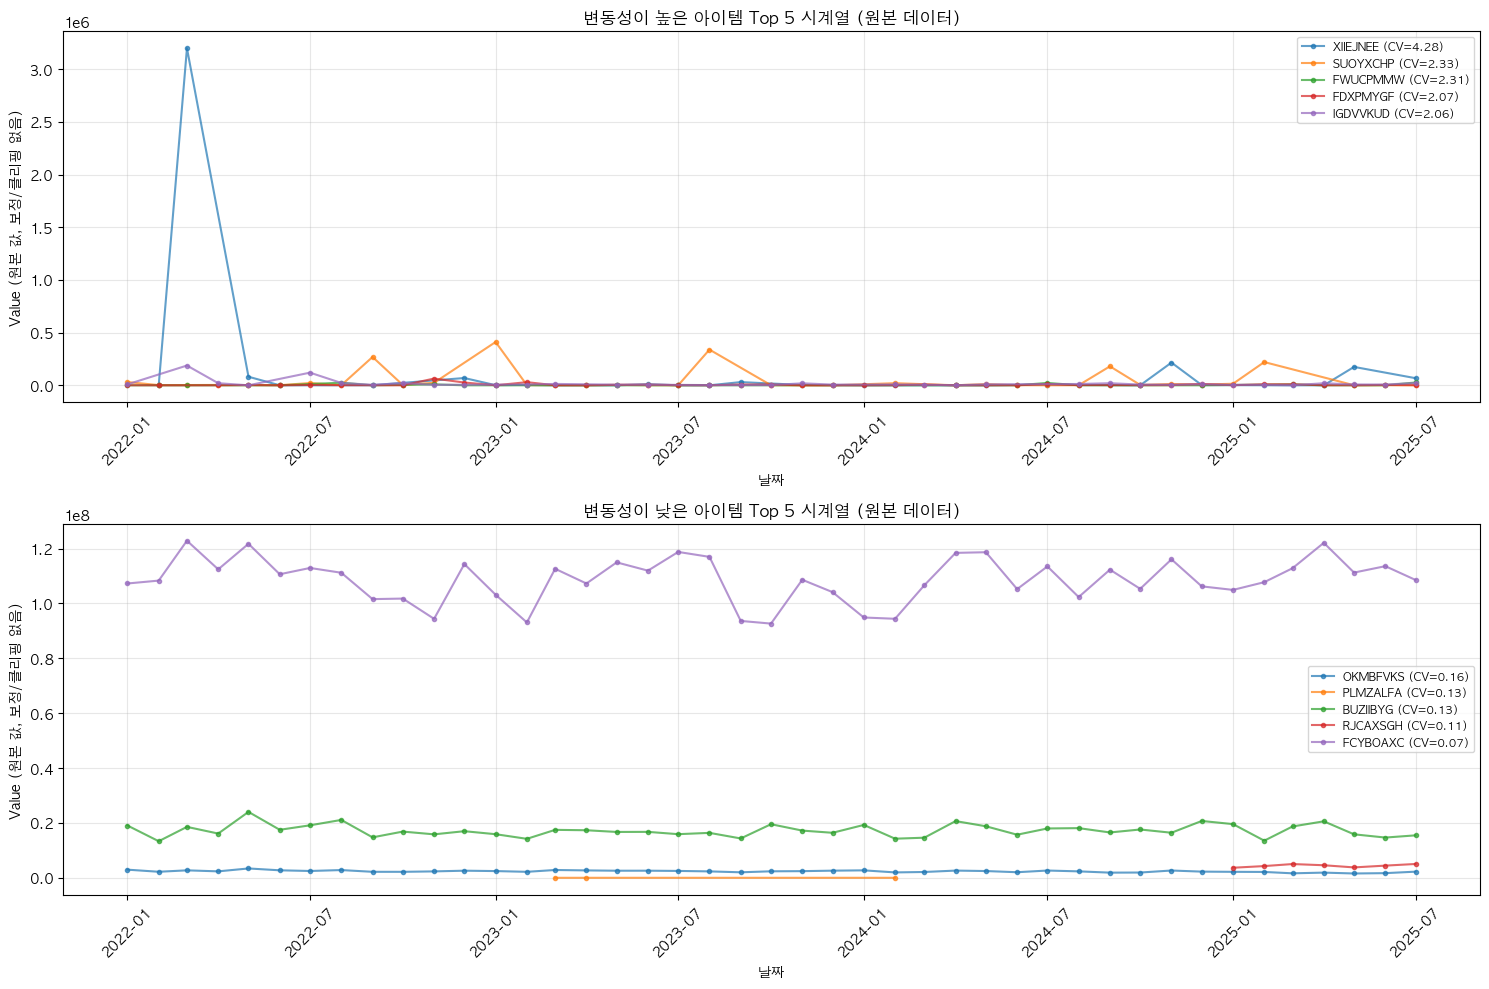

In [16]:
# 4. 변동성이 높은/낮은 아이템의 시계열 플롯 (원본 데이터)
high_volatile_items = volatility_df_sorted.head(5)['item_id'].tolist()
low_volatile_items = volatility_df_sorted.tail(5)['item_id'].tolist()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 4-1. 변동성이 높은 아이템 시계열 (원본 value_sum 사용)
for item_id in high_volatile_items:
    item_data = monthly_features[monthly_features['item_id'] == item_id].sort_values('ym')
    if len(item_data) > 0:
        cv_value = volatility_df[volatility_df['item_id'] == item_id]['cv_value'].values
        cv_str = f'{cv_value[0]:.2f}' if len(cv_value) > 0 else 'N/A'
        axes[0].plot(item_data['ym'], item_data['value_sum'], 
                    marker='o', markersize=3, label=f'{item_id} (CV={cv_str})', 
                    linewidth=1.5, alpha=0.7)

axes[0].set_xlabel('날짜')
axes[0].set_ylabel('Value (원본 값, 보정/클리핑 없음)')
axes[0].set_title('변동성이 높은 아이템 Top 5 시계열 (원본 데이터)')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 4-2. 변동성이 낮은 아이템 시계열 (원본 value_sum 사용)
for item_id in low_volatile_items:
    item_data = monthly_features[monthly_features['item_id'] == item_id].sort_values('ym')
    if len(item_data) > 0:
        cv_value = volatility_df[volatility_df['item_id'] == item_id]['cv_value'].values
        cv_str = f'{cv_value[0]:.2f}' if len(cv_value) > 0 else 'N/A'
        axes[1].plot(item_data['ym'], item_data['value_sum'], 
                    marker='o', markersize=3, label=f'{item_id} (CV={cv_str})', 
                    linewidth=1.5, alpha=0.7)

axes[1].set_xlabel('날짜')
axes[1].set_ylabel('Value (원본 값, 보정/클리핑 없음)')
axes[1].set_title('변동성이 낮은 아이템 Top 5 시계열 (원본 데이터)')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


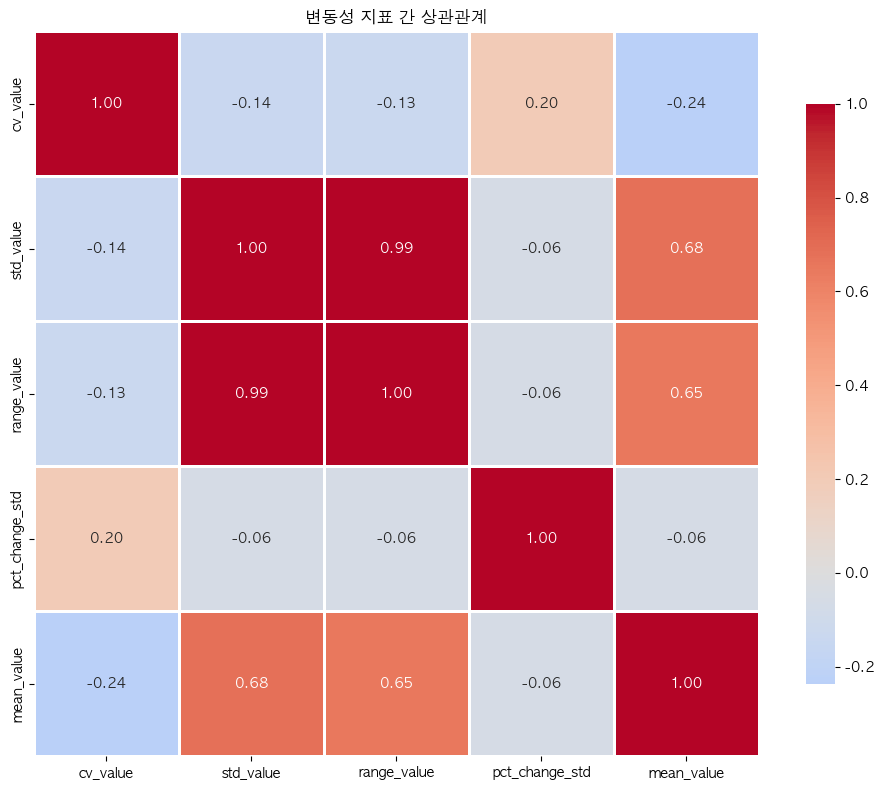


변동성 지표 간 상관계수:
                cv_value  std_value  range_value  pct_change_std  mean_value
cv_value        1.000000  -0.142097    -0.133283        0.199904   -0.236366
std_value      -0.142097   1.000000     0.991175       -0.060389    0.680160
range_value    -0.133283   0.991175     1.000000       -0.059742    0.650654
pct_change_std  0.199904  -0.060389    -0.059742        1.000000   -0.058015
mean_value     -0.236366   0.680160     0.650654       -0.058015    1.000000


In [17]:
# 5. 변동성 지표 간 상관관계 분석
fig, ax = plt.subplots(figsize=(10, 8))

# 변동성 지표 간 상관계수 계산
corr_cols = ['cv_value', 'std_value', 'range_value', 'pct_change_std', 'mean_value']
corr_matrix = volatility_df[corr_cols].corr()

# 히트맵 생성
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('변동성 지표 간 상관관계')
plt.tight_layout()
plt.show()

print("\n변동성 지표 간 상관계수:")
print(corr_matrix)


In [18]:
# 6. 변동성 정보를 monthly_features에 추가 (선택사항)
# 변동성 지표를 원본 데이터에 merge하여 활용 가능
if len(volatility_df) > 0:
    volatility_summary = volatility_df[['item_id', 'cv_value', 'std_value', 'range_value', 'pct_change_std']].copy()
    volatility_summary.columns = ['item_id', 'item_cv_value', 'item_std_value', 'item_range_value', 'item_pct_change_std']
    
    # Merge (선택사항 - 필요시 주석 해제)
    # monthly_features = monthly_features.merge(volatility_summary, on='item_id', how='left')
    
    print("="*70)
    print("아이템별 변동성 시각화 완료!")
    print("="*70)
    print(f"\n변동성 지표 요약:")
    print(f"  - 평균 변동계수: {volatility_df['cv_value'].mean():.2f}")
    print(f"  - 중앙값 변동계수: {volatility_df['cv_value'].median():.2f}")
    
    if len(volatility_df) > 0:
        max_idx = volatility_df['cv_value'].idxmax()
        min_idx = volatility_df['cv_value'].idxmin()
        print(f"  - 최대 변동계수: {volatility_df.loc[max_idx, 'cv_value']:.2f} (item_id: {volatility_df.loc[max_idx, 'item_id']})")
        print(f"  - 최소 변동계수: {volatility_df.loc[min_idx, 'cv_value']:.2f} (item_id: {volatility_df.loc[min_idx, 'item_id']})")
    
    print(f"\n변동성 지표 데이터프레임 shape: {volatility_df.shape}")
    print(f"변동성 지표 데이터프레임 컬럼: {volatility_df.columns.tolist()}")
else:
    print("경고: 변동성 지표를 계산할 수 있는 아이템이 없습니다.")


아이템별 변동성 시각화 완료!

변동성 지표 요약:
  - 평균 변동계수: 0.83
  - 중앙값 변동계수: 0.67
  - 최대 변동계수: 4.28 (item_id: XIIEJNEE)
  - 최소 변동계수: 0.07 (item_id: FCYBOAXC)

변동성 지표 데이터프레임 shape: (99, 14)
변동성 지표 데이터프레임 컬럼: ['item_id', 'hs4', 'cluster', 'n_months', 'n_nonzero', 'mean_value', 'std_value', 'cv_value', 'range_value', 'max_value', 'min_value', 'std_log_value', 'pct_change_std', 'zero_ratio']


In [19]:
# 0값 처리와 스케일 안정을 위해 log1p 사용
monthly_features['log_value'] = np.log1p(monthly_features['value_clip'])
monthly_features['log_weight'] = np.log1p(monthly_features['weight_clip'])
monthly_features['log_quantity'] = np.log1p(monthly_features['quantity_clip'])

print("로그 변환 완료")
monthly_features[['value_clip', 'log_value', 'weight_clip', 'log_weight', 
                  'quantity_clip', 'log_quantity']].head(10)


로그 변환 완료


,value_clip,log_value,weight_clip,log_weight,quantity_clip,log_quantity
0,14276.0,9.566405,17625.0,9.777130,0.0,0.0
1,52347.0,10.865669,67983.0,11.127028,0.0,0.0
2,53549.0,10.888371,69544.0,11.149729,0.0,0.0
3,26997.0,10.203518,34173.0,10.439220,0.0,0.0
4,84489.0,11.344388,103666.0,11.548939,0.0,0.0
5,299.0,5.703782,67.0,4.219508,0.0,0.0
6,574.0,6.354370,66.0,4.204693,0.0,0.0
7,41353.0,10.629924,50281.0,10.825402,0.0,0.0
8,26524.0,10.185843,32345.0,10.384246,0.0,0.0
9,340.0,5.831882,70.0,4.262680,0.0,0.0


## 📈 아이템별 시계열 변화 시각화

각 아이템 ID의 시계열 변화를 확인할 수 있습니다.


In [ ]:
# ============================================================
# 모든 아이템의 시계열 변화 시각화
# ============================================================

# 1. 클러스터별로 그룹화하여 시계열 플롯
clusters = monthly_features['cluster'].unique()
n_clusters = len(clusters)

fig, axes = plt.subplots(n_clusters, 1, figsize=(18, 6 * n_clusters))
if n_clusters == 1:
    axes = [axes]

for idx, cluster in enumerate(clusters):
    cluster_items = monthly_features[monthly_features['cluster'] == cluster]['item_id'].unique()
    
    for item_id in cluster_items:
        item_data = monthly_features[
            (monthly_features['item_id'] == item_id) & 
            (monthly_features['cluster'] == cluster)
        ].sort_values('ym')
        
        if len(item_data) > 0:
            axes[idx].plot(item_data['ym'], item_data['value_sum'], 
                          marker='o', markersize=2, label=item_id, 
                          linewidth=1, alpha=0.6)
    
    axes[idx].set_xlabel('날짜 (Year-Month)', fontsize=12)
    axes[idx].set_ylabel('Value (원본 값)', fontsize=12)
    axes[idx].set_title(f'{cluster} 클러스터 - 모든 아이템 시계열', fontsize=14, fontweight='bold')
    axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=2)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n총 {len(monthly_features['item_id'].unique())}개 아이템의 시계열을 클러스터별로 표시했습니다.")


In [ ]:
# ============================================================
# 개별 아이템 선택하여 상세 시계열 확인
# ============================================================

# 확인하고 싶은 아이템 ID를 선택 (예시: 상위 10개 아이템)
top_items = volatility_df.nlargest(10, 'mean_value')['item_id'].tolist()

print("="*70)
print("개별 아이템 시계열 상세 분석")
print("="*70)
print(f"분석할 아이템: {top_items}\n")

# 2x5 그리드로 각 아이템별 시계열 플롯
n_items = len(top_items)
n_cols = 5
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten() if n_items > 1 else [axes]

for idx, item_id in enumerate(top_items):
    item_data = monthly_features[monthly_features['item_id'] == item_id].sort_values('ym')
    
    if len(item_data) > 0:
        # 원본 값
        axes[idx].plot(item_data['ym'], item_data['value_sum'], 
                      marker='o', markersize=4, linewidth=2, 
                      color='blue', label='원본 (value_sum)')
        
        # 보정된 값 (있는 경우)
        if 'value_filled' in item_data.columns:
            axes[idx].plot(item_data['ym'], item_data['value_filled'], 
                          marker='s', markersize=3, linewidth=1.5, 
                          color='orange', alpha=0.7, label='보정 (value_filled)')
        
        # 클리핑된 값 (있는 경우)
        if 'value_clip' in item_data.columns:
            axes[idx].plot(item_data['ym'], item_data['value_clip'], 
                          marker='^', markersize=3, linewidth=1.5, 
                          color='green', alpha=0.7, label='클리핑 (value_clip)')
        
        # 아이템 정보
        cluster = item_data['cluster'].iloc[0] if 'cluster' in item_data.columns else 'N/A'
        hs4 = item_data['hs4'].iloc[0] if 'hs4' in item_data.columns else 'N/A'
        mean_val = item_data['value_sum'].mean()
        
        axes[idx].set_title(f'{item_id}\n(Cluster: {cluster}, HS4: {hs4})', 
                           fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('날짜', fontsize=9)
        axes[idx].set_ylabel('Value', fontsize=9)
        axes[idx].legend(fontsize=7, loc='best')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
        
        # 통계 정보 텍스트로 표시
        stats_text = f'평균: {mean_val:,.0f}\n최대: {item_data["value_sum"].max():,.0f}'
        axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                      fontsize=8, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    else:
        axes[idx].text(0.5, 0.5, f'{item_id}\n데이터 없음', 
                      transform=axes[idx].transAxes,
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(item_id, fontsize=10)

# 사용하지 않는 subplot 숨기기
for idx in range(n_items, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n{len(top_items)}개 아이템의 상세 시계열을 표시했습니다.")


In [ ]:
# ============================================================
# 특정 아이템 ID를 입력하여 시계열 확인
# ============================================================

# 확인하고 싶은 아이템 ID를 여기에 입력하세요
TARGET_ITEM_IDS = ['AANGBULD', 'APQGTRMF', 'BEZYMBBT']  # 예시: 원하는 아이템 ID 리스트

print("="*70)
print("특정 아이템 시계열 분석")
print("="*70)

for item_id in TARGET_ITEM_IDS:
    item_data = monthly_features[monthly_features['item_id'] == item_id].sort_values('ym')
    
    if len(item_data) == 0:
        print(f"\n⚠️  {item_id}: 데이터를 찾을 수 없습니다.")
        continue
    
    # 아이템 정보
    cluster = item_data['cluster'].iloc[0] if 'cluster' in item_data.columns else 'N/A'
    hs4 = item_data['hs4'].iloc[0] if 'hs4' in item_data.columns else 'N/A'
    
    print(f"\n{item_id} 정보:")
    print(f"  - Cluster: {cluster}")
    print(f"  - HS4: {hs4}")
    print(f"  - 데이터 기간: {item_data['ym'].min()} ~ {item_data['ym'].max()}")
    print(f"  - 총 {len(item_data)}개월 데이터")
    print(f"  - 평균 값: {item_data['value_sum'].mean():,.0f}")
    print(f"  - 최대 값: {item_data['value_sum'].max():,.0f}")
    print(f"  - 최소 값: {item_data['value_sum'].min():,.0f}")
    print(f"  - 표준편차: {item_data['value_sum'].std():,.0f}")

# 시계열 플롯
fig, axes = plt.subplots(len(TARGET_ITEM_IDS), 1, figsize=(16, 5 * len(TARGET_ITEM_IDS)))
if len(TARGET_ITEM_IDS) == 1:
    axes = [axes]

for idx, item_id in enumerate(TARGET_ITEM_IDS):
    item_data = monthly_features[monthly_features['item_id'] == item_id].sort_values('ym')
    
    if len(item_data) == 0:
        continue
    
    cluster = item_data['cluster'].iloc[0] if 'cluster' in item_data.columns else 'N/A'
    hs4 = item_data['hs4'].iloc[0] if 'hs4' in item_data.columns else 'N/A'
    
    # 원본 값
    axes[idx].plot(item_data['ym'], item_data['value_sum'], 
                  marker='o', markersize=6, linewidth=2.5, 
                  color='blue', label='원본 (value_sum)', alpha=0.8)
    
    # 보정된 값
    if 'value_filled' in item_data.columns:
        axes[idx].plot(item_data['ym'], item_data['value_filled'], 
                      marker='s', markersize=4, linewidth=1.5, 
                      color='orange', alpha=0.6, label='보정 (value_filled)')
    
    # 클리핑된 값
    if 'value_clip' in item_data.columns:
        axes[idx].plot(item_data['ym'], item_data['value_clip'], 
                      marker='^', markersize=4, linewidth=1.5, 
                      color='green', alpha=0.6, label='클리핑 (value_clip)')
    
    axes[idx].set_title(f'{item_id} - {cluster} (HS4: {hs4})', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('날짜 (Year-Month)', fontsize=12)
    axes[idx].set_ylabel('Value', fontsize=12)
    axes[idx].legend(fontsize=10, loc='best')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)
    
    # 통계 정보
    mean_val = item_data['value_sum'].mean()
    max_val = item_data['value_sum'].max()
    min_val = item_data['value_sum'].min()
    std_val = item_data['value_sum'].std()
    
    stats_text = f'평균: {mean_val:,.0f}\n최대: {max_val:,.0f}\n최소: {min_val:,.0f}\n표준편차: {std_val:,.0f}'
    axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                  fontsize=10, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\n✅ {len(TARGET_ITEM_IDS)}개 아이템의 시계열 분석 완료!")
print("\n💡 TARGET_ITEM_IDS 변수를 수정하여 원하는 아이템을 확인할 수 있습니다.")


## 🔟 최종 컬럼 구성 및 저장


In [20]:
# 최종 컬럼 순서 정리
final_columns = [
    # 식별자/키
    'item_id', 'hs4', 'hs2', 'year', 'month', 'ym', 'cluster',
    # 집계 원본
    'value_sum', 'weight_sum', 'quantity_sum',
    # 결측/0값/플래그
    'has_quantity_info_hs4', 'has_quantity_this_row',
    'weight_zero_flag', 'value_zero_flag',
    'weight_missing_flag', 'value_missing_flag',
    'value_extreme_flag', 'weight_extreme_flag', 'quantity_extreme_flag',
    # 보정·클리핑
    'weight_filled', 'value_filled',
    'value_clip', 'weight_clip', 'quantity_clip',
    # 로그 피처
    'log_value', 'log_weight', 'log_quantity'
]

monthly_features = monthly_features[final_columns]

print("="*70)
print("전처리 완료!")
print("="*70)
print(f"최종 데이터 shape: {monthly_features.shape}")
print(f"컬럼 수: {len(monthly_features.columns)}")
print("\n최종 컬럼 목록:")
for col in monthly_features.columns:
    print(f"  - {col}")

monthly_features.head()


전처리 완료!
최종 데이터 shape: (3776, 27)
컬럼 수: 27

최종 컬럼 목록:
  - item_id
  - hs4
  - hs2
  - year
  - month
  - ym
  - cluster
  - value_sum
  - weight_sum
  - quantity_sum
  - has_quantity_info_hs4
  - has_quantity_this_row
  - weight_zero_flag
  - value_zero_flag
  - weight_missing_flag
  - value_missing_flag
  - value_extreme_flag
  - weight_extreme_flag
  - quantity_extreme_flag
  - weight_filled
  - value_filled
  - value_clip
  - weight_clip
  - quantity_clip
  - log_value
  - log_weight
  - log_quantity


,item_id,hs4,hs2,year,month,ym,cluster,value_sum,weight_sum,quantity_sum,...,weight_extreme_flag,quantity_extreme_flag,weight_filled,value_filled,value_clip,weight_clip,quantity_clip,log_value,log_weight,log_quantity
0,AANGBULD,4810,48,2022,1,2022-01-01,other_industries,14276.0,17625.0,0.0,...,0,0,17625.0,14276.0,14276.0,17625.0,0.0,9.566405,9.777130,0.0
1,AANGBULD,4810,48,2022,2,2022-02-01,other_industries,52347.0,67983.0,0.0,...,0,0,67983.0,52347.0,52347.0,67983.0,0.0,10.865669,11.127028,0.0
2,AANGBULD,4810,48,2022,3,2022-03-01,other_industries,53549.0,69544.0,0.0,...,0,0,69544.0,53549.0,53549.0,69544.0,0.0,10.888371,11.149729,0.0
3,AANGBULD,4810,48,2022,5,2022-05-01,other_industries,26997.0,34173.0,0.0,...,0,0,34173.0,26997.0,26997.0,34173.0,0.0,10.203518,10.439220,0.0
4,AANGBULD,4810,48,2022,6,2022-06-01,other_industries,84489.0,103666.0,0.0,...,0,0,103666.0,84489.0,84489.0,103666.0,0.0,11.344388,11.548939,0.0


In [21]:
# CSV 저장
output_path = 'monthly_features.csv'
monthly_features.to_csv(output_path, index=False)
print(f"\n결과 저장 완료: {output_path}")
print(f"파일 크기: {Path(output_path).stat().st_size / 1024 / 1024:.2f} MB")



결과 저장 완료: monthly_features.csv
파일 크기: 0.63 MB
